In [2]:
import os
import json
import sqlite3
import pandas as pd
import datetime
import decimal
import matplotlib.pyplot as plt

In [3]:
all_events = []
for root,directories, files in os.walk('../nni'):
    for file in files:
        file_name = '{}/{}'.format(root,file)
        meta_data = file_name.split('/')
        experiment_id = meta_data[3]
        if 'log' in file_name or 'run.sh' in file_name or 'stderr' in file_name:
            continue
        if 'sqlite' in file_name:
                try:
                    conn = sqlite3.connect(file_name)
                    c = conn.cursor()
                    c.execute('SELECT * FROM TrialJobEvent')
                    result = c.fetchall()
                    all_events+=[{'time_point':  datetime.datetime.fromtimestamp(i[0]/1000),
                                  'experiment_id': experiment_id,
                                  'trial_id': i[1],
                                  'type': i[2],
                                  'queue': json.loads(i[3])['parameter_id'] if i[3] else None,
                                  'batch': json.loads(i[3])['parameters']['batch'] if i[3] else None,
                                  'hidden_factors': json.loads(i[3])['parameters']['hidden_factors'] if i[3] else None,
                                  'regularizer': json.loads(i[3])['parameters']['regularizer'] if i[3] else None,
                                 } for i in result] 
                finally:
                    conn.close()

In [4]:
all_events_df = pd.DataFrame(all_events)
all_events_df['duration'] = 0

In [5]:
for trial_id, body in all_events_df.groupby('trial_id'):
    begin_time = body[body['type']=='RUNNING']['time_point'].array
    end_time = body[body['type']=='SUCCEEDED']['time_point'].array
    if end_time.size == 0:
        all_events_df = all_events_df[all_events_df['trial_id']!=trial_id]
    else:
        all_events_df.loc[all_events_df['trial_id']==trial_id, 'duration'] = (end_time[0] - begin_time[0]).total_seconds()

In [6]:
all_events_df = all_events_df[all_events_df['type']=='WAITING'].drop(columns=['type'])
all_events_df['value'] = 0
all_events_df['method'] = ''
all_events_df

,time_point,experiment_id,trial_id,queue,batch,hidden_factors,regularizer,duration,value,method
0,2020-07-12 14:08:30.026,zgNIwuIH,K4kLH,0,64.0,64.0,-4.299037,10930.493,0,
2,2020-07-12 14:10:30.212,zgNIwuIH,pu8pT,1,256.0,128.0,-5.671608,4528.161,0,
3,2020-07-12 14:10:30.216,zgNIwuIH,sdDyq,2,512.0,32.0,-6.808246,1756.478,0,
4,2020-07-12 14:10:30.219,zgNIwuIH,kwhLc,3,256.0,128.0,-6.859900,4074.489,0,
9,2020-07-12 14:39:56.768,zgNIwuIH,ybIuh,4,64.0,16.0,-7.222800,10622.249,0,
...,...,...,...,...,...,...,...,...,...,...
972,2020-07-11 12:31:36.254,kED1A1n8,H6OOX,25,128.0,4.0,-5.000000,5500.077,0,
975,2020-07-11 12:35:17.593,kED1A1n8,hJtpA,26,128.0,4.0,-5.000000,5459.160,0,
978,2020-07-11 12:37:53.554,kED1A1n8,MUnws,27,128.0,4.0,-4.000000,5467.229,0,
981,2020-07-11 12:43:00.375,kED1A1n8,HRFZI,28,128.0,4.0,-4.000000,5554.405,0,


In [46]:
with open('experiment_model2.json', 'r') as f:
    data_json = json.loads(f.read())

In [47]:
for k, v in data_json.items():
    for trial in v['trials']:
        if 'trial_job_id' not in trial:
            continue
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'value'] = float(trial['value'])
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'method'] = v['method']

In [48]:
duration_df = pd.DataFrame([{'method': method,
  'duration':sum(data['duration'])
 } for method, data in all_events_df.groupby('method')])

In [49]:
duration_df = duration_df.sort_values(['duration'])

In [50]:
duration_df

,method,duration
4,GPTuner,82004.559
0,Anneal,84535.219
9,Random,97019.786
6,Hyperband,115052.275
3,Evolution,118551.221
8,PBTTuner,124015.607
1,BOHB,137717.401
7,MetisTuner,138459.825
10,TPE,139668.683
2,BatchTuner,162184.746


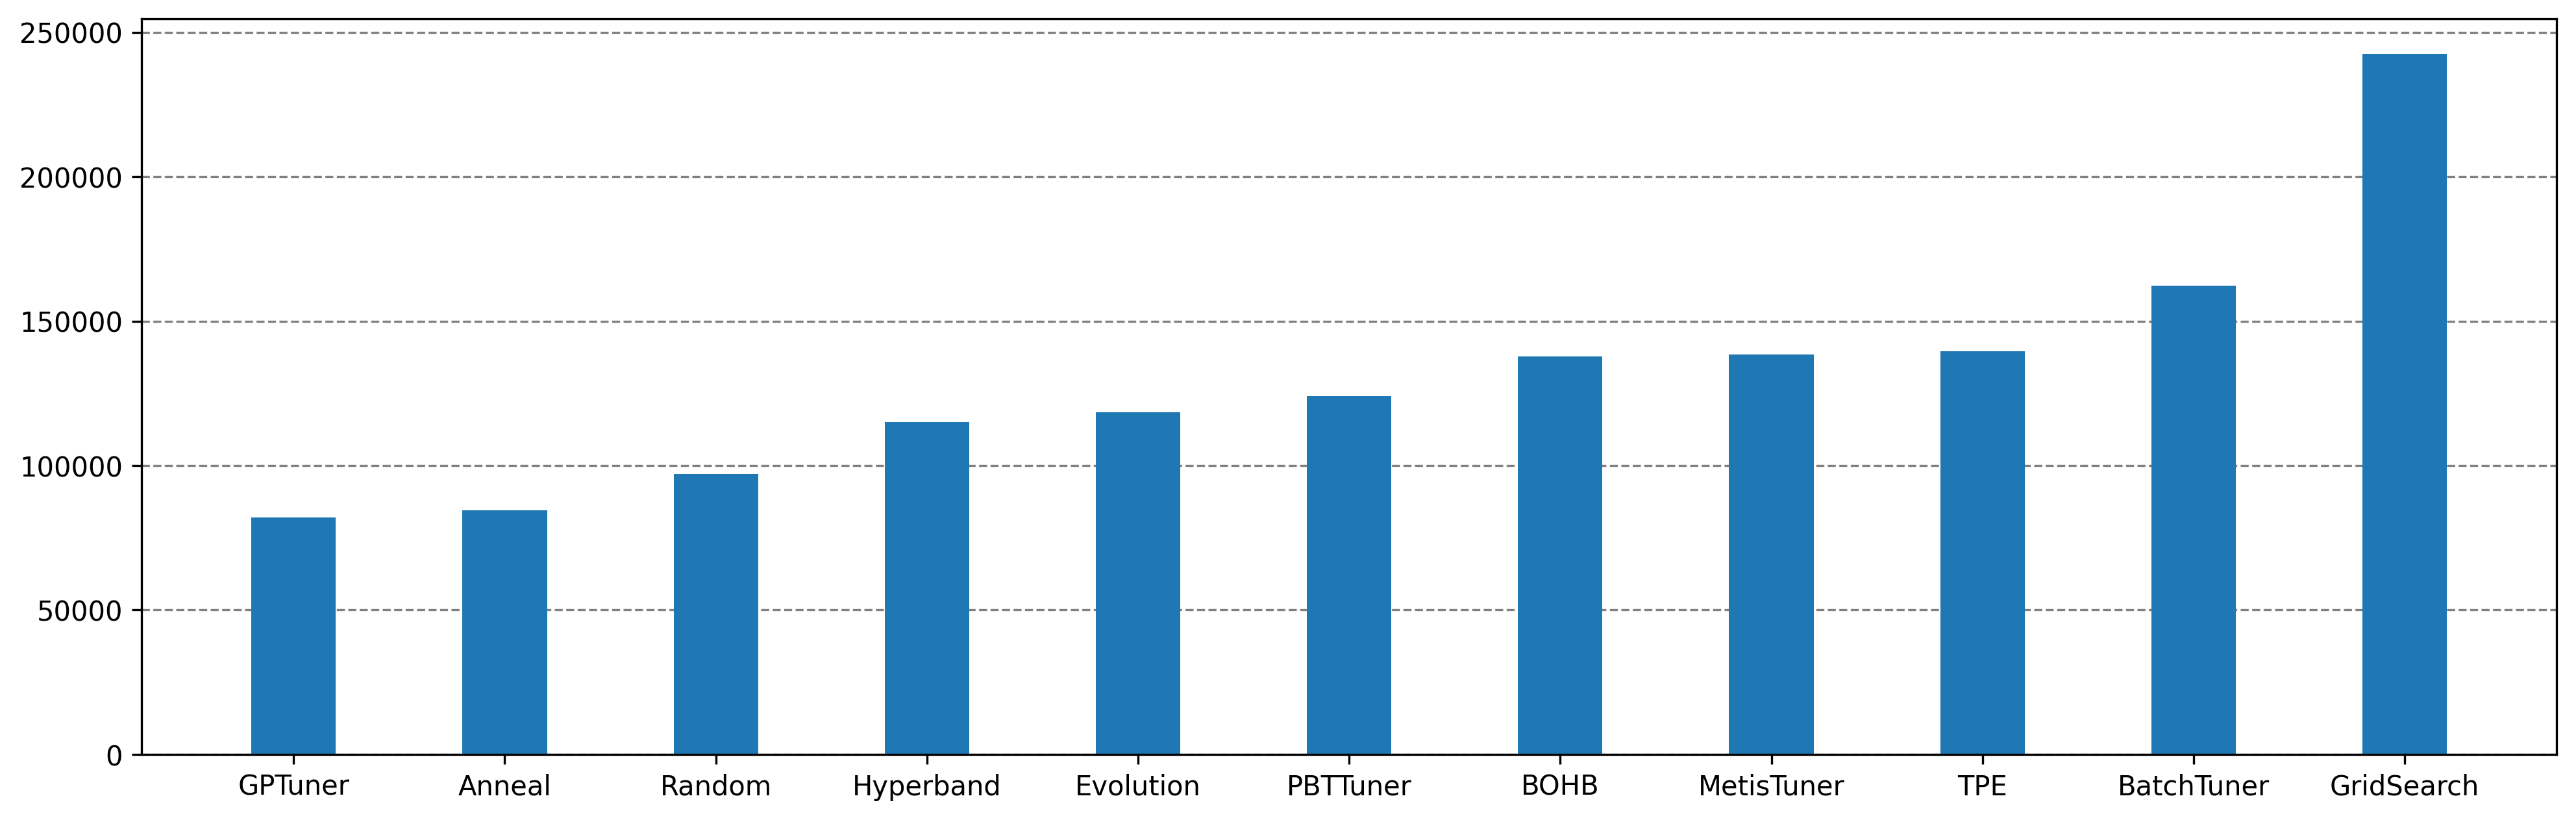

In [51]:
fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.bar(duration_df['method'], duration_df['duration'], width=0.4)
plt.show()

In [52]:
print([i for i in all_events_df['method'].unique()])
print([i for i in all_events_df.columns])

['MetisTuner', 'Hyperband', 'PBTTuner', 'TPE', 'Anneal', 'BatchTuner', 'GPTuner', 'BOHB', 'Random', 'Evolution', 'GridSearch']
['time_point', 'experiment_id', 'trial_id', 'queue', 'batch', 'hidden_factors', 'regularizer', 'duration', 'value', 'method']


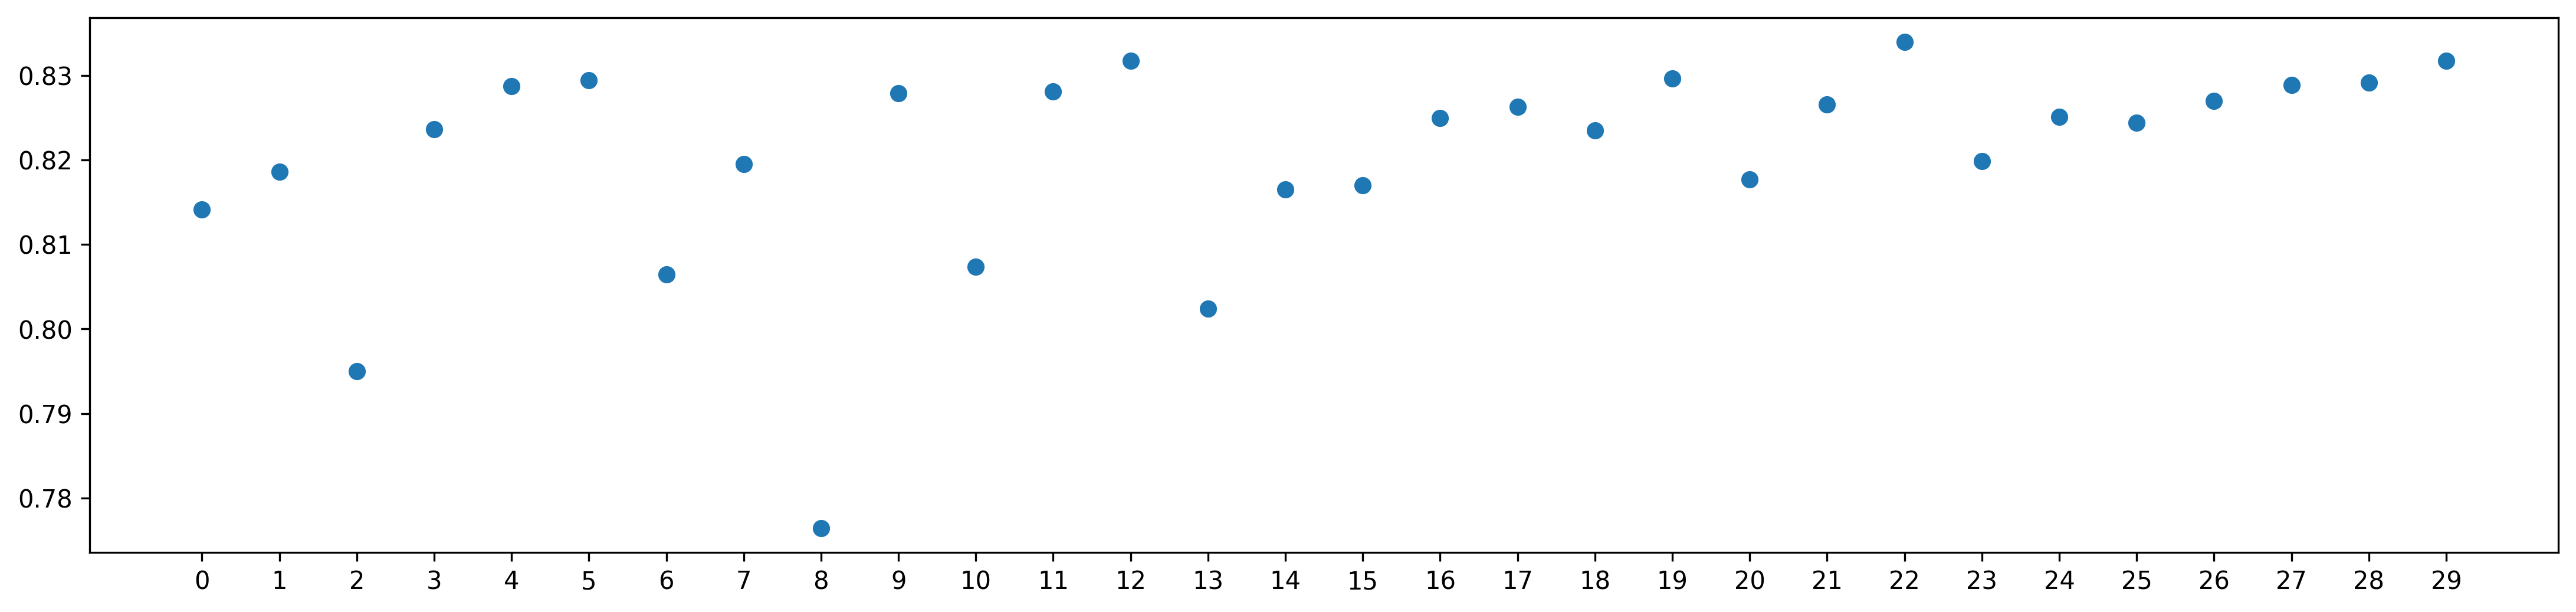

In [69]:
single_method = all_events_df[all_events_df['method']=='PBTTuner']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index)
plt.show()

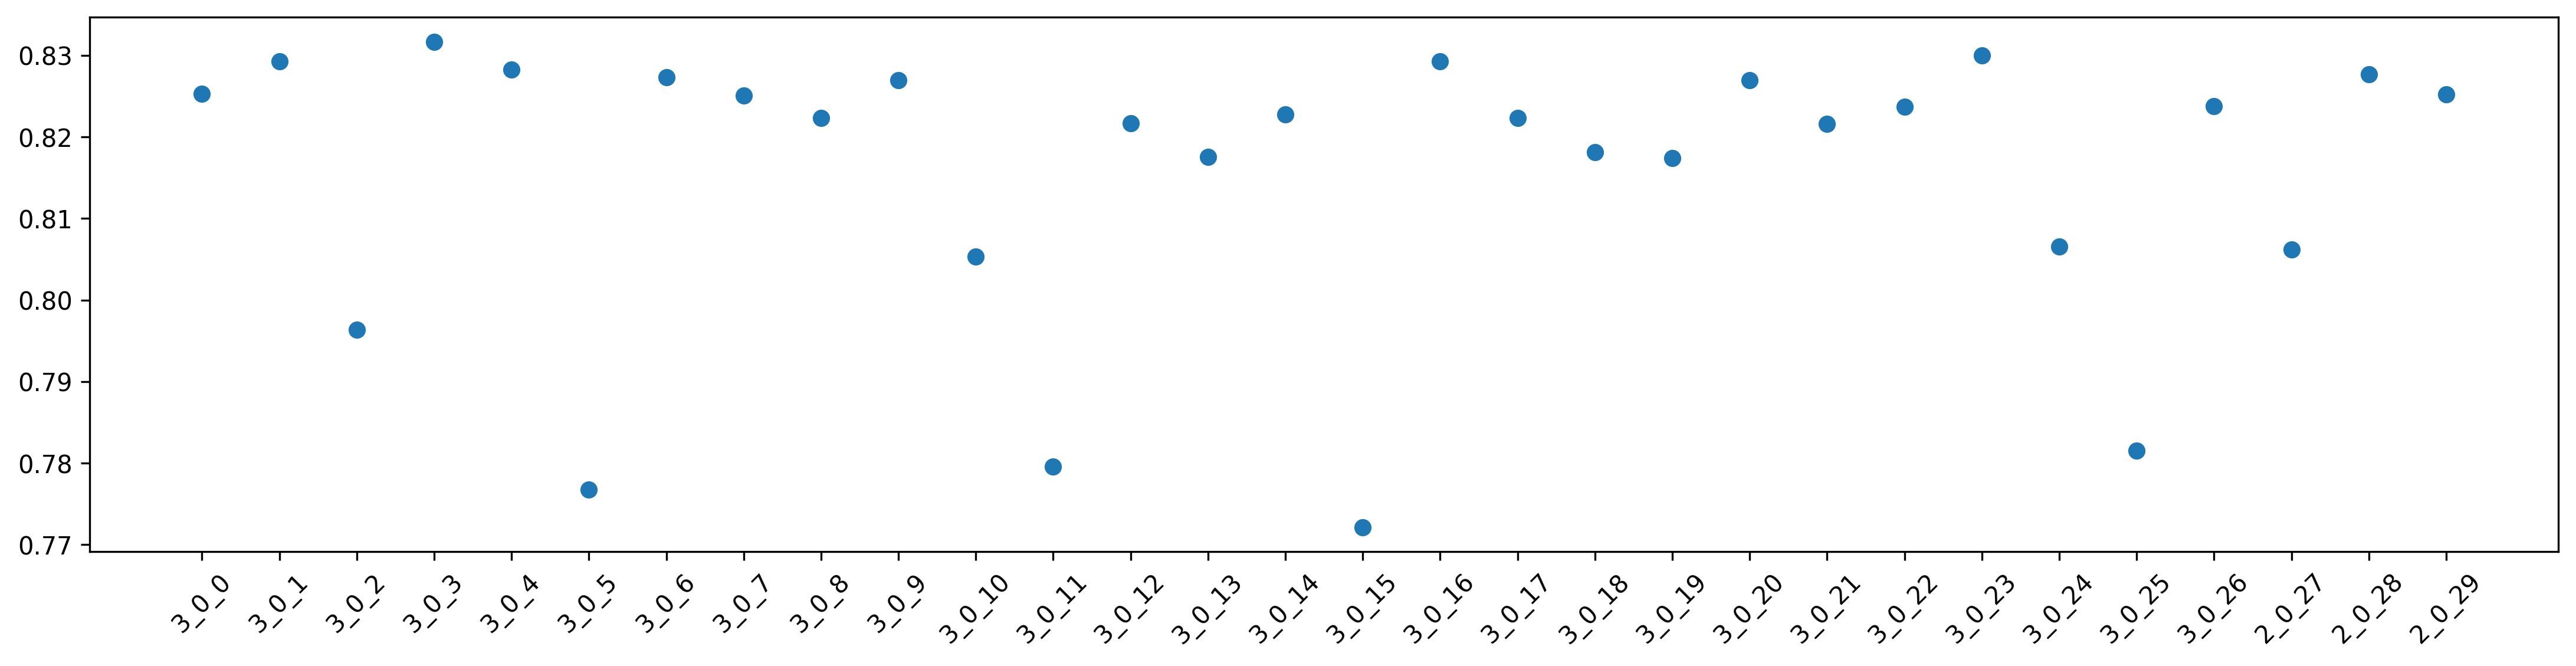

In [71]:
single_method = all_events_df[all_events_df['method']=='Hyperband']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index, rotation=45)
plt.show()